## Speech Emotion Recognition Pipeline

I will be using RAVDESS Emotional speech audio dataset.

### Imports & Setup

In [39]:
import sys
!{sys.executable} -m pip install resampy --user

In [ ]:
# 1. IMPORTS
import os
import sys
import random
import warnings

import pandas as pd
import numpy as np

import librosa
import librosa.display
import IPython.display as ipd

import matplotlib.pyplot as plt
import seaborn as sns

import resampy

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

warnings.filterwarnings('ignore')

# 2. SEED SETTING (Reproducibility)
# This ensures that our "random" splits are the same every time I run the code.
# Vital for scientific comparison.
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True

# 3. DEVICE CHECK
def get_device():
    if torch.cuda.is_available():
        device_name = torch.cuda.get_device_name(0)
        print(f" GPU Detected: {device_name}")
        print(f"   Memory Usage: {torch.cuda.memory_allocated(0)/1024**3:.2f} GB / {torch.cuda.memory_reserved(0)/1024**3:.2f} GB")
        return torch.device('cuda')
    else:
        print(" No GPU detected. Running on CPU.")
        print("   Note: Training Deep Learning models (Phase 3) will be slow.")
        return torch.device('cpu')

device = get_device()

# 4. SYSTEM INFO SUMMARY
print("-" * 30)
print(f"Python Version: {sys.version.split()[0]}")
print(f"PyTorch Version: {torch.__version__}")
print(f"Librosa Version: {librosa.__version__}")
print(f"Device set to: {device}")
print("-" * 30)

### Data Loading and Parsing


In [41]:
import os
import pandas as pd


# CONFIGURATION
# Update this path to where your RAVDESS folder is located
# Link to DS: https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio
DATASET_PATH = "./RAVDESS_Audio/"

# Mappings based on the RAVDESS filename convention
# Filename example: 03-01-06-01-02-01-12.wav
emotion_map = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

intensity_map = {
    '01': 'normal',
    '02': 'strong'
}

def load_ravdess_data(path):
    """
    Scans the directory for .wav files and parses filenames
    to extract labels (Emotion, Intensity, Gender, Actor ID).
    """
    file_list = []

    # Walk through all directories and files
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.endswith('.wav'):
                # parsing the filename
                # Example: 03-01-06-01-02-01-12.wav
                parts = file.split('.')[0].split('-')

                # Safety check: ensure filename has 7 parts
                if len(parts) != 7:
                    continue

                emotion_code = parts[2]
                intensity_code = parts[3]
                actor_code = parts[6]

                # Logic: Odd actors = Male, Even actors = Female
                actor_id = int(actor_code)
                gender = 'female' if (actor_id % 2 == 0) else 'male'

                # Store data
                file_list.append({
                    'path': os.path.join(root, file),
                    'filename': file,
                    'emotion': emotion_map.get(emotion_code, 'unknown'),
                    'intensity': intensity_map.get(intensity_code, 'unknown'),
                    'gender': gender,
                    'actor_id': actor_id
                })

    # Create DataFrame
    df = pd.DataFrame(file_list)
    return df


# EXECUTION

print("Scanning dataset...")
df = load_ravdess_data(DATASET_PATH)

# Display results
print(f"Total files found: {len(df)}")
print("\nSample Data:")
print(df.head())

# Check for class balance
print("\nEmotion Distribution:")
print(df['emotion'].value_counts())

Scanning dataset...
Total files found: 2880

Sample Data:
                                                path  \
0  ./RAVDESS_Audio/Actor_01\03-01-01-01-01-01-01.wav   
1  ./RAVDESS_Audio/Actor_01\03-01-01-01-01-02-01.wav   
2  ./RAVDESS_Audio/Actor_01\03-01-01-01-02-01-01.wav   
3  ./RAVDESS_Audio/Actor_01\03-01-01-01-02-02-01.wav   
4  ./RAVDESS_Audio/Actor_01\03-01-02-01-01-01-01.wav   

                   filename  emotion intensity gender  actor_id  
0  03-01-01-01-01-01-01.wav  neutral    normal   male         1  
1  03-01-01-01-01-02-01.wav  neutral    normal   male         1  
2  03-01-01-01-02-01-01.wav  neutral    normal   male         1  
3  03-01-01-01-02-02-01.wav  neutral    normal   male         1  
4  03-01-02-01-01-01-01.wav     calm    normal   male         1  

Emotion Distribution:
emotion
calm         384
happy        384
sad          384
angry        384
disgust      384
fearful      384
surprised    384
neutral      192
Name: count, dtype: int64


### Phase 2: Feature Extraction

#### 2.1. FE Code

In [42]:
import time
from tqdm import tqdm # Progress bar

# CONFIGURATION
N_MFCC = 40

def extract_features(file_path):
    """
    Loads an audio file and calculates the mean MFCCs.
    Result is a fixed-size vector (array of 40 numbers) regardless of audio length.
    """
    try:
        # Load audio file
        # librosa converts audio to a floating point time series
        # sr=None preserves the native sampling rate
        audio, sample_rate = librosa.load(file_path)

        # Extract MFCCs
        # This returns an array of shape (n_mfcc, time_steps)
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=N_MFCC)

        # Aggregate across time (taking the mean)
        # get a fixed-size vector for every file
        mfccs_scaled = np.mean(mfccs.T, axis=0)

        return mfccs_scaled

    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# EXECUTION

print("Starting Feature Extraction (MFCCs)... this may take a few minutes.")
start_time = time.time()

features = []
labels = []

for index, row in tqdm(df.iterrows(), total=df.shape[0]):
    path = row['path']
    label = row['emotion']

    # Extract
    data = extract_features(path)

    if data is not None:
        features.append(data)
        labels.append(label)

X = pd.DataFrame(features)
y = pd.Series(labels)

end_time = time.time()
print(f"\nExtraction complete in {end_time - start_time:.2f} seconds.")
print(f"Feature Matrix Shape: {X.shape}") # Should be (2880, 40)
print(f"Labels Shape: {y.shape}")

Starting Feature Extraction (MFCCs)... this may take a few minutes.


100%|██████████| 2880/2880 [00:16<00:00, 174.10it/s]


Extraction complete in 16.57 seconds.
Feature Matrix Shape: (2880, 40)
Labels Shape: (2880,)


#### 2.2. Visualisation

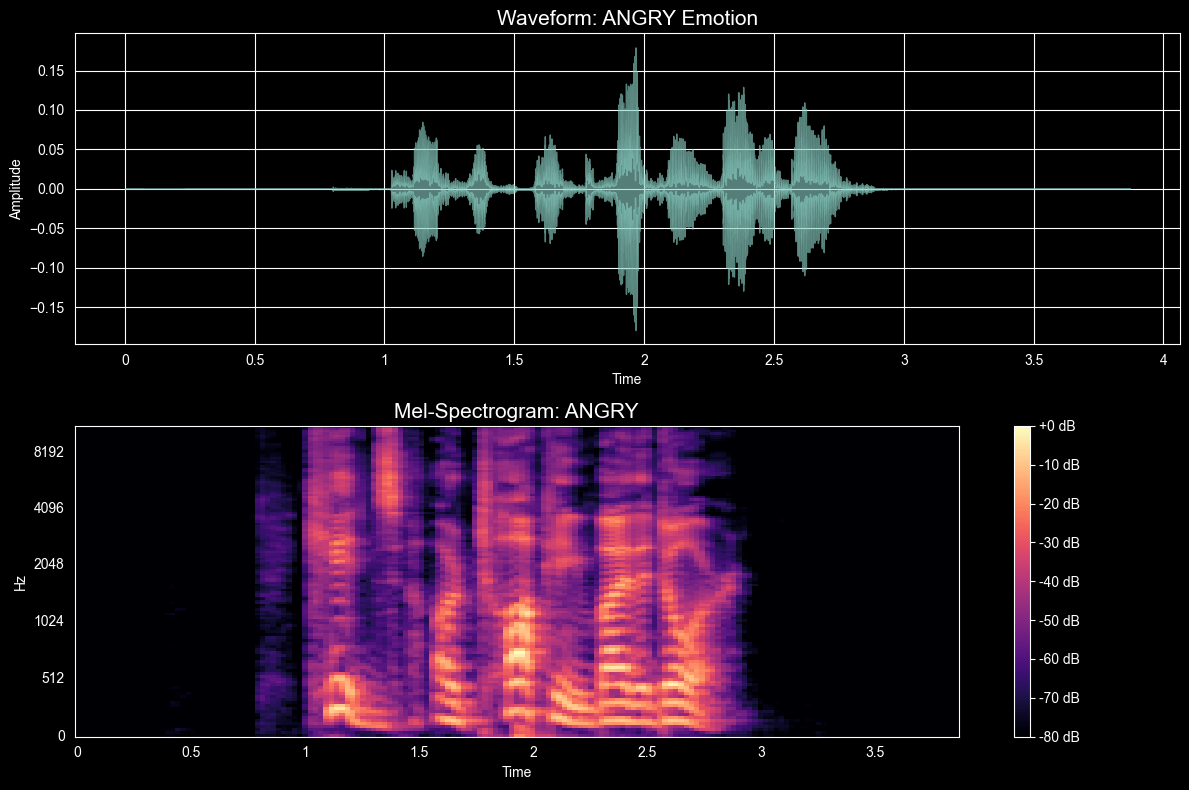

In [43]:
def plot_spectrogram_and_wave(row_index):
    """
    Plots the Waveform and Mel-Spectrogram for a specific file in the dataset.
    """
    # Get file path from our dataframe
    file_path = df.iloc[row_index]['path']
    emotion = df.iloc[row_index]['emotion']

    # Load audio
    y, sr = librosa.load(file_path)

    plt.figure(figsize=(12, 8))

    # 1. Waveform Plot
    plt.subplot(2, 1, 1)
    librosa.display.waveshow(y, sr=sr, alpha=0.6)
    plt.title(f'Waveform: {emotion.upper()} Emotion', fontsize=15)
    plt.ylabel('Amplitude')

    # 2. Spectrogram Plot
    plt.subplot(2, 1, 2)
    # Convert to Mel-Spectrogram
    S = librosa.feature.melspectrogram(y=y, sr=sr)
    S_dB = librosa.power_to_db(S, ref=np.max)
    librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Mel-Spectrogram: {emotion.upper()}', fontsize=15)

    plt.tight_layout()
    plt.show()

# Visualize a random "Angry" file (usually has high energy)
angry_indices = df[df['emotion'] == 'angry'].index
if len(angry_indices) > 0:
    plot_spectrogram_and_wave(angry_indices[0])
else:
    plot_spectrogram_and_wave(0)

### Phase 3: Training

#### 3.1. Baseline (classic ML)

Splitting data by Actor ID (Subject-Independent)...
Train Actors: [np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(10), np.int64(11), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(18), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24)]
Test Actors:  [np.int64(1), np.int64(9), np.int64(12), np.int64(17), np.int64(19)]

Training SVM on Subject-Independent Split...

Baseline Accuracy: 36.33%
------------------------------------------------------------
              precision    recall  f1-score   support

       angry       0.62      0.65      0.63        80
        calm       0.36      0.62      0.46        80
     disgust       0.53      0.20      0.29        80
     fearful       0.29      0.40      0.33        80
       happy       0.25      0.28      0.26        80
     neutral       0.25      0.20      0.22        40
         sad       0.25      0.23      0.24        80
   surprised       0.45 

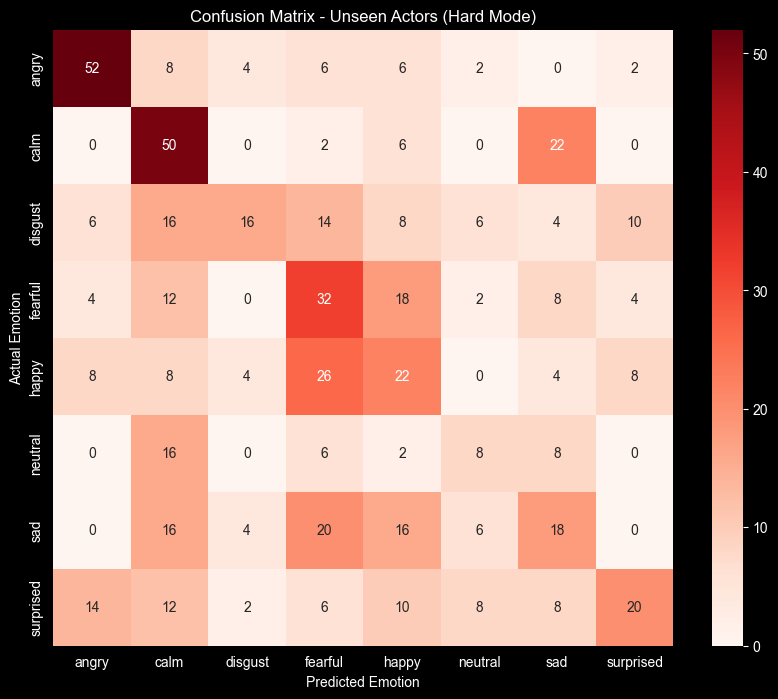

In [44]:
from sklearn.model_selection import GroupShuffleSplit
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1. SPLIT BY ACTOR
print("Splitting data by Actor ID (Subject-Independent)...")

# I use GroupShuffleSplit to ensure actors don't leak between sets
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
groups = df['actor_id']

# Generate the indices for the split
train_idx, test_idx = next(gss.split(X, y, groups=groups))

# Create the sets using standard names so the next cells work
X_train = X.iloc[train_idx]
X_test = X.iloc[test_idx]
y_train = y.iloc[train_idx]
y_test = y.iloc[test_idx]

# Print check to confirm no actor overlap
print(f"Train Actors: {sorted(df.iloc[train_idx]['actor_id'].unique())}")
print(f"Test Actors:  {sorted(df.iloc[test_idx]['actor_id'].unique())}")


# 2. SCALE DATA
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 3. TRAIN BASELINE (SVM)
print("\nTraining SVM on Subject-Independent Split...")
model = SVC(kernel='rbf', C=10, gamma='scale', probability=True)
model.fit(X_train_scaled, y_train)

# 4. EVALUATE
y_pred = model.predict(X_test_scaled)
acc = accuracy_score(y_test, y_pred)

print(f"\nBaseline Accuracy: {acc*100:.2f}%")
print("-" * 60)
print(classification_report(y_test, y_pred))

# Visualization
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Confusion Matrix - Unseen Actors (Hard Mode)')
plt.ylabel('Actual Emotion')
plt.xlabel('Predicted Emotion')
plt.show()

#### 3.2. Deep Learning


Training Deep Learning Model on cuda...
Epoch [10/60] - Loss: 66.9032 - Accuracy: 67.32%
Epoch [20/60] - Loss: 43.1043 - Accuracy: 79.34%
Epoch [30/60] - Loss: 33.3541 - Accuracy: 83.46%
Epoch [40/60] - Loss: 27.7005 - Accuracy: 85.96%
Epoch [50/60] - Loss: 23.3924 - Accuracy: 88.25%
Epoch [60/60] - Loss: 20.9405 - Accuracy: 90.48%

Deep Learning Model Evaluation:
              precision    recall  f1-score   support

       angry       0.60      0.60      0.60        80
        calm       0.38      0.30      0.33        80
     disgust       0.41      0.33      0.36        80
     fearful       0.48      0.50      0.49        80
       happy       0.32      0.25      0.28        80
     neutral       0.00      0.00      0.00        40
         sad       0.17      0.40      0.24        80
   surprised       0.43      0.30      0.35        80

    accuracy                           0.36       600
   macro avg       0.35      0.33      0.33       600
weighted avg       0.37      0.36    

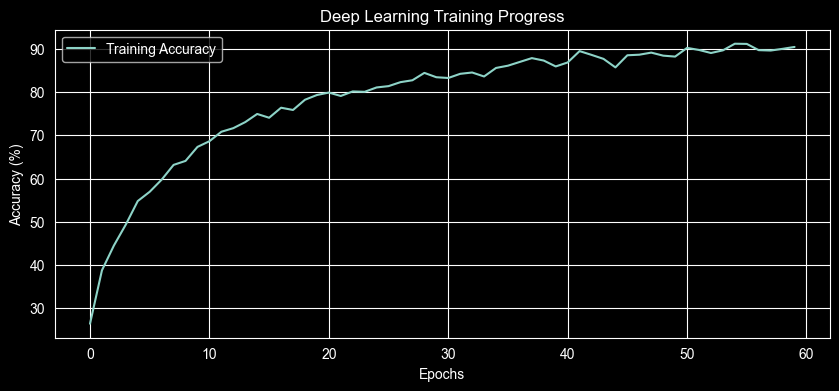

In [45]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
import numpy as np


# 1. PREPARE DATA FOR PYTORCH

# STEP A: ENCODE LABELS
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# STEP B: CREATE TENSORS
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_encoded, dtype=torch.long)

X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_encoded, dtype=torch.long)

# Custom Dataset Class
class EmotionDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create Data Loaders
train_dataset = EmotionDataset(X_train_tensor, y_train_tensor)
test_dataset = EmotionDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


# 2. DEFINE THE DEEP LEARNING MODEL

class DeepEmotionNet(nn.Module):
    def __init__(self, input_size, num_classes):
        super(DeepEmotionNet, self).__init__()
        # A 4-layer Deep Neural Network
        self.layer1 = nn.Linear(input_size, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.4)

        self.layer2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)

        self.layer3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)

        self.output = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.dropout(self.relu(self.bn1(self.layer1(x))))
        x = self.dropout(self.relu(self.bn2(self.layer2(x))))
        x = self.dropout(self.relu(self.bn3(self.layer3(x))))
        x = self.output(x)
        return x

# Initialize Model
model_dl = DeepEmotionNet(input_size=40, num_classes=8).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_dl.parameters(), lr=0.0005)


# 3. TRAIN THE MODEL
print(f"Training Deep Learning Model on {device}...")
epochs = 60
loss_history = []
acc_history = []

for epoch in range(epochs):
    model_dl.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model_dl(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_acc = 100 * correct / total
    loss_history.append(running_loss)
    acc_history.append(epoch_acc)

    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}] - Loss: {running_loss:.4f} - Accuracy: {epoch_acc:.2f}%")


# 4. EVALUATION
model_dl.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_dl(inputs)
        _, predicted = torch.max(outputs.data, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("\nDeep Learning Model Evaluation:")
print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))

plt.figure(figsize=(10, 4))
plt.plot(acc_history, label='Training Accuracy')
plt.title('Deep Learning Training Progress')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

#### 3.2. LSTM Model (fix for above)

In [46]:
import numpy as np
import librosa
import pandas as pd
from tqdm import tqdm
import time


# CONFIGURATION
# clip all audio to exactly 3 seconds (standard for RAVDESS)
# If shorter, pad. If longer, cut.
MAX_LEN = 150  # Time steps (approx 3 seconds of audio frames)
N_MFCC = 40    # Number of frequency features

def extract_sequence_features(file_path, max_len=MAX_LEN):
    try:
        audio, sample_rate = librosa.load(file_path, sr=None)

        # Extract MFCCs (Result: n_mfcc x time_steps)
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=N_MFCC)

        # Transpose so time is the first dimension (time_steps x n_mfcc)
        mfccs = mfccs.T

        # PAD OR TRUNCATE to ensure fixed size
        if mfccs.shape[0] < max_len:
            # Pad with zeros if too short
            pad_width = max_len - mfccs.shape[0]
            mfccs = np.pad(mfccs, ((0, pad_width), (0, 0)), mode='constant')
        else:
            # Truncate if too long
            mfccs = mfccs[:max_len, :]

        return mfccs

    except Exception as e:
        return None


# EXECUTION
print("Starting Sequence Extraction (for LSTM)...")
start_time = time.time()

features_seq = []
labels_seq = []

for index, row in tqdm(df.iterrows(), total=df.shape[0]):
    path = row['path']
    label = row['emotion']

    data = extract_sequence_features(path)

    if data is not None:
        features_seq.append(data)
        labels_seq.append(label)

# Convert to NumPy Arrays (Better for 3D data than Pandas)
X_seq = np.array(features_seq) # Shape: (2880, 150, 40)
y_seq = np.array(labels_seq)

end_time = time.time()
print(f"\nExtraction complete in {end_time - start_time:.2f} seconds.")
print(f"3D Feature Matrix Shape: {X_seq.shape}") # Should be (Samples, TimeSteps, Features)

Starting Sequence Extraction (for LSTM)...


100%|██████████| 2880/2880 [00:19<00:00, 149.66it/s]


Extraction complete in 19.29 seconds.
3D Feature Matrix Shape: (2880, 150, 40)


In [47]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt

# 1. SPLIT DATA (Subject Independent)
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
groups = df['actor_id']
train_idx, test_idx = next(gss.split(X_seq, y_seq, groups=groups))

X_train = X_seq[train_idx]
y_train = y_seq[train_idx]
X_test = X_seq[test_idx]
y_test = y_seq[test_idx]

# Encode Labels
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_test_enc = label_encoder.transform(y_test)

# Convert to PyTorch Tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_enc, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_enc, dtype=torch.long)

# Data Loaders
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


# 2. DEFINE LSTM MODEL
class EmotionLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(EmotionLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # LSTM Layer: Processes the sequence
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.3)

        # Fully Connected Layer: Maps final state to classes
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Initialize hidden state and cell state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))

        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

# Initialize
model_lstm = EmotionLSTM(input_size=40, hidden_size=128, num_layers=2, num_classes=8).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_lstm.parameters(), lr=0.001)


# 3. TRAIN
print(f"Training LSTM on {device}...")
epochs = 40
acc_history = []

for epoch in range(epochs):
    model_lstm.train()
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model_lstm(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    acc = 100 * correct / total
    acc_history.append(acc)
    if (epoch+1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{epochs}] - Accuracy: {acc:.2f}%")

# 4. EVALUATE
model_lstm.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_lstm(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("\nLSTM Evaluation (Subject Independent):")
print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))

Training LSTM on cuda...
Epoch [5/40] - Accuracy: 57.72%
Epoch [10/40] - Accuracy: 73.20%
Epoch [15/40] - Accuracy: 84.82%
Epoch [20/40] - Accuracy: 87.94%
Epoch [25/40] - Accuracy: 96.58%
Epoch [30/40] - Accuracy: 97.46%
Epoch [35/40] - Accuracy: 96.54%
Epoch [40/40] - Accuracy: 97.32%

LSTM Evaluation (Subject Independent):
              precision    recall  f1-score   support

       angry       0.72      0.45      0.55        80
        calm       0.28      0.12      0.17        80
     disgust       0.36      0.47      0.41        80
     fearful       0.46      0.33      0.38        80
       happy       0.59      0.33      0.42        80
     neutral       0.47      0.40      0.43        40
         sad       0.20      0.57      0.30        80
   surprised       0.35      0.20      0.25        80

    accuracy                           0.36       600
   macro avg       0.43      0.36      0.37       600
weighted avg       0.43      0.36      0.36       600



#### 3.4. Data Augmentation

In [48]:

# PHASE 3.4: DATA AUGMENTATION (IMPROVEMENT)
import numpy as np
import librosa
import time
from tqdm import tqdm

print("Starting Phase 3.4: Augmented Feature Extraction...")
start_time = time.time()

# 1. Define Augmentation Wrappers
def get_augmented_features(file_path, max_len=150):
    """Returns a list of 4 feature matrices for a single file"""
    results = []
    try:
        audio, sr = librosa.load(file_path, sr=None)

        # Create 4 versions
        versions = [
            audio,                                   # Original
            audio + 0.005 * np.random.randn(len(audio)), # Noise
            librosa.effects.pitch_shift(y=audio, sr=sr, n_steps=2), # Pitch
            librosa.effects.time_stretch(y=audio, rate=1.2) # Speed
        ]

        for y_ver in versions:
            # Extract
            mfccs = librosa.feature.mfcc(y=y_ver, sr=sr, n_mfcc=40).T
            # Pad/Truncate
            if mfccs.shape[0] < max_len:
                pad = max_len - mfccs.shape[0]
                mfccs = np.pad(mfccs, ((0, pad), (0, 0)), mode='constant')
            else:
                mfccs = mfccs[:max_len, :]
            results.append(mfccs)

        return results
    except:
        return None

# 2. Run Extraction
X_seq_aug = []
y_seq_aug = []
groups_aug = []

for index, row in tqdm(df.iterrows(), total=df.shape[0]):
    path = row['path']
    label = row['emotion']
    actor = row['actor_id']

    # Get 4x features
    feats = get_augmented_features(path)

    if feats:
        for f in feats:
            X_seq_aug.append(f)
            y_seq_aug.append(label)
            groups_aug.append(actor) # important for splitting

# Convert to arrays
X_seq_aug = np.array(X_seq_aug)
y_seq_aug = np.array(y_seq_aug)
groups_aug = np.array(groups_aug)

print(f"\nOriginal Dataset Size: {len(df)}")
print(f"Augmented Dataset Size: {len(X_seq_aug)}") # Should be ~5760

Starting Phase 3.4: Augmented Feature Extraction...


100%|██████████| 2880/2880 [04:41<00:00, 10.25it/s]



Original Dataset Size: 2880
Augmented Dataset Size: 11520


#### 3.5. training Augmented LTSM

Training Augmented LSTM (Subject Independent)...
Epoch [10/40] - Aug Accuracy: 76.34%
Epoch [20/40] - Aug Accuracy: 93.50%
Epoch [30/40] - Aug Accuracy: 96.50%
Epoch [40/40] - Aug Accuracy: 96.95%

 Final Evaluation (Augmented Data):
              precision    recall  f1-score   support

       angry       0.66      0.51      0.58       320
        calm       0.38      0.55      0.45       320
     disgust       0.29      0.46      0.36       320
     fearful       0.37      0.35      0.36       320
       happy       0.46      0.34      0.39       320
     neutral       0.33      0.23      0.27       160
         sad       0.23      0.32      0.27       320
   surprised       0.38      0.09      0.15       320

    accuracy                           0.37      2400
   macro avg       0.39      0.36      0.35      2400
weighted avg       0.39      0.37      0.36      2400



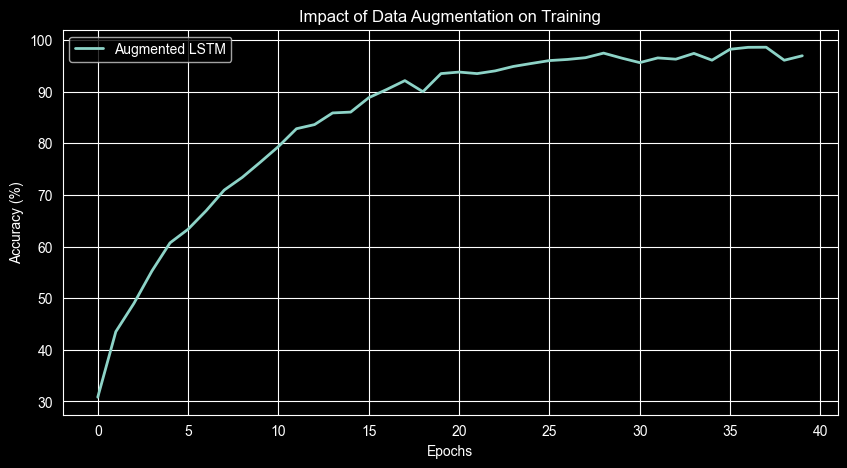

In [49]:

# TRAINING AUGMENTED LSTM
print("Training Augmented LSTM (Subject Independent)...")

# 1. SPLIT using the new augmented groups)
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X_seq_aug, y_seq_aug, groups=groups_aug))

X_train_aug = X_seq_aug[train_idx]
y_train_aug = y_seq_aug[train_idx]
X_test_aug = X_seq_aug[test_idx]
y_test_aug = y_seq_aug[test_idx]

# 2. ENCODE & TENSOR
le_aug = LabelEncoder()
y_train_enc = le_aug.fit_transform(y_train_aug)
y_test_enc = le_aug.transform(y_test_aug)

# Convert to Tensors (Float32 for features, Long for labels)
train_ds_aug = torch.utils.data.TensorDataset(
    torch.tensor(X_train_aug, dtype=torch.float32),
    torch.tensor(y_train_enc, dtype=torch.long)
)
test_ds_aug = torch.utils.data.TensorDataset(
    torch.tensor(X_test_aug, dtype=torch.float32),
    torch.tensor(y_test_enc, dtype=torch.long)
)

# Loaders (Batch size 64 for speed)
train_loader_aug = DataLoader(train_ds_aug, batch_size=64, shuffle=True)
test_loader_aug = DataLoader(test_ds_aug, batch_size=64, shuffle=False)

# 3. DEFINE NEW MODEL
# I re-initialize the same architecture
model_lstm_aug = EmotionLSTM(input_size=40, hidden_size=128, num_layers=2, num_classes=8).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_lstm_aug.parameters(), lr=0.001)

# 4. TRAIN
epochs = 40
aug_acc_history = []

for epoch in range(epochs):
    model_lstm_aug.train()
    correct = 0
    total = 0

    for inputs, labels in train_loader_aug:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model_lstm_aug(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    acc = 100 * correct / total
    aug_acc_history.append(acc)

    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}] - Aug Accuracy: {acc:.2f}%")

# 5. EVALUATE
print("\nFinal Evaluation (Augmented Data):")
model_lstm_aug.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader_aug:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_lstm_aug(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(classification_report(all_labels, all_preds, target_names=le_aug.classes_))

# 6. PLOT COMPARISON
plt.figure(figsize=(10, 5))
plt.plot(aug_acc_history, label='Augmented LSTM', linewidth=2)
plt.title('Impact of Data Augmentation on Training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

### Phase 4: Big Data solution: wav2vec2

#### 4.1. Pre-trained model

In [50]:
import sys
!{sys.executable} -m pip install transformers datasets --user

In [51]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import Wav2Vec2Processor, Wav2Vec2Model
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
import librosa

# 1. SETUP & CONFIGURATION
MODEL_NAME = "facebook/wav2vec2-base-960h"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Loading Wav2Vec2 Model: {MODEL_NAME}...")
processor = Wav2Vec2Processor.from_pretrained(MODEL_NAME)
# Freeze the base model effectively to use it as a 'Feature Extractor'
base_model = Wav2Vec2Model.from_pretrained(MODEL_NAME).to(device)


# 2. DATASET CLASS (On-the-fly Processing)
# Unlike before, I don't pre-extract features
# I feed raw audio into the Transformer
class RawAudioDataset(Dataset):
    def __init__(self, df, processor, max_length=16000*3): # 3 seconds
        self.paths = df['path'].values
        self.labels = df['label_encoded'].values
        self.processor = processor
        self.max_length = max_length

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        label = self.labels[idx]

        # Load Raw Audio
        audio, sr = librosa.load(path, sr=16000) # Wav2Vec2 requires 16k Hz

        # Pad or Truncate
        if len(audio) > self.max_length:
            audio = audio[:self.max_length]
        else:
            padding = self.max_length - len(audio)
            audio = np.pad(audio, (0, padding), 'constant')

        # Process input (Normalize)
        inputs = self.processor(audio, sampling_rate=16000, return_tensors="pt", padding=True)

        # I return the raw input values (Vector of size ~48000)
        return inputs.input_values.squeeze(), torch.tensor(label, dtype=torch.long)

# 3. PREPARE DATA SPLIT
# Encode Labels
le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['emotion'])

# Hard split (subject independent)
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(df, df['label_encoded'], groups=df['actor_id']))

train_df = df.iloc[train_idx]
test_df = df.iloc[test_idx]

# Create Datasets
train_dataset = RawAudioDataset(train_df, processor)
test_dataset = RawAudioDataset(test_df, processor)

# Reduce batch size to 8 or 4 to fit in GPU Memory (Transformers are huge)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)


# 4. DEFINE CUSTOM HEAD
class EmotionClassifier(nn.Module):
    def __init__(self, base_model, num_classes):
        super(EmotionClassifier, self).__init__()
        self.base_model = base_model

        # Wav2Vec2 Base output is (Batch, Time, 768)
        # I need to map 768 -> 8 emotions
        self.classifier = nn.Sequential(
            nn.Linear(768, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, input_values):
        # Pass through Pre-trained Transformer
        with torch.no_grad(): # Don't train the giant model (saves memory)
            outputs = self.base_model(input_values)
            # Take the average over time (Pool the results)
            hidden_states = outputs.last_hidden_state.mean(dim=1)

        # Pass through our classifier
        logits = self.classifier(hidden_states)
        return logits

# Initialize
model_transfer = EmotionClassifier(base_model, num_classes=8).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_transfer.parameters(), lr=0.001)


# 5. TRAIN
print("Training Transfer Learning Model (Wav2Vec2)...")
epochs = 15 # Converges faster
acc_history = []

for epoch in range(epochs):
    model_transfer.train()
    correct = 0
    total = 0
    running_loss = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model_transfer(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        running_loss += loss.item()

    acc = 100 * correct / total
    acc_history.append(acc)
    print(f"Epoch [{epoch+1}/{epochs}] - Loss: {running_loss:.2f} - Accuracy: {acc:.2f}%")

# ==========================================
# 6. EVALUATE
# ==========================================
print("\nFinal SOTA Evaluation:")
model_transfer.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_transfer(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

from sklearn.metrics import classification_report
print(classification_report(all_labels, all_preds, target_names=le.classes_))

Loading Wav2Vec2 Model: facebook/wav2vec2-base-960h...


Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training Transfer Learning Model (Wav2Vec2)...
Epoch [1/15] - Loss: 592.51 - Accuracy: 14.87%
Epoch [2/15] - Loss: 583.95 - Accuracy: 15.92%
Epoch [3/15] - Loss: 576.66 - Accuracy: 18.07%
Epoch [4/15] - Loss: 575.53 - Accuracy: 19.25%
Epoch [5/15] - Loss: 570.04 - Accuracy: 19.78%
Epoch [6/15] - Loss: 564.94 - Accuracy: 21.01%
Epoch [7/15] - Loss: 560.24 - Accuracy: 22.15%
Epoch [8/15] - Loss: 561.05 - Accuracy: 21.93%
Epoch [9/15] - Loss: 560.35 - Accuracy: 21.40%
Epoch [10/15] - Loss: 553.56 - Accuracy: 22.50%
Epoch [11/15] - Loss: 557.41 - Accuracy: 20.96%
Epoch [12/15] - Loss: 557.73 - Accuracy: 22.72%
Epoch [13/15] - Loss: 557.91 - Accuracy: 21.80%
Epoch [14/15] - Loss: 558.10 - Accuracy: 22.06%
Epoch [15/15] - Loss: 556.51 - Accuracy: 23.20%

 Final SOTA Evaluation:
              precision    recall  f1-score   support

       angry       0.67      0.05      0.09        80
        calm       0.18      0.97      0.30        80
     disgust       0.33      0.05      0.09        80


#### 4.2. Fine-tuning

In [53]:

# PHASE 4: SOTA (Wav2Vec2 Fine-Tuning)
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import Wav2Vec2Processor, Wav2Vec2Model
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np
import librosa

# 1. SETUP
MODEL_NAME = "facebook/wav2vec2-base-960h"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Loading Wav2Vec2: {MODEL_NAME}")

processor = Wav2Vec2Processor.from_pretrained(MODEL_NAME)
# I load the base model here, but I will pass it to the FineTuner class below
base_model_initial = Wav2Vec2Model.from_pretrained(MODEL_NAME)

# 2. DATASET (Raw Audio)
class RawAudioDataset(Dataset):
    def __init__(self, df, processor, max_length=16000*3):
        self.paths = df['path'].values
        # Encode labels on the fly if not already in df
        self.labels = LabelEncoder().fit_transform(df['emotion'])
        self.processor = processor
        self.max_length = max_length

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        label = self.labels[idx]

        # Load Raw Audio (16kHz is mandatory for Wav2Vec2)
        audio, sr = librosa.load(path, sr=16000)

        # Pad/Truncate
        if len(audio) > self.max_length:
            audio = audio[:self.max_length]
        else:
            padding = self.max_length - len(audio)
            audio = np.pad(audio, (0, padding), 'constant')

        inputs = self.processor(audio, sampling_rate=16000, return_tensors="pt", padding=True)
        return inputs.input_values.squeeze(), torch.tensor(label, dtype=torch.long)

# 3. SPLIT DATA (Subject Independent)
# I use the ORIGINAL df (Wav2Vec2 is too heavy for 4x augmented data on laptop GPU)
le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['emotion'])

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(df, df['label_encoded'], groups=df['actor_id']))

train_dataset = RawAudioDataset(df.iloc[train_idx], processor)
test_dataset = RawAudioDataset(df.iloc[test_idx], processor)

# Batch size 4 to prevent OOM
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

# 4. DEFINE FINE-TUNER
class EmotionFineTuner(nn.Module):
    def __init__(self, base_model, num_classes):
        super(EmotionFineTuner, self).__init__()
        self.base_model = base_model

        # UNFREEZE THE MODEL
        for param in self.base_model.parameters():
            param.requires_grad = True

        self.classifier = nn.Sequential(
            nn.Linear(768, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )

    def forward(self, input_values):
        outputs = self.base_model(input_values)
        hidden_states = outputs.last_hidden_state
        pooled_output = torch.mean(hidden_states, dim=1)
        return self.classifier(pooled_output)

# Initialize
model_ft = EmotionFineTuner(base_model_initial, num_classes=8).to(device)

# 5. OPTIMIZER (Differential Learning Rate)
# Low LR for base model (so I don t break it), High LR for head
optimizer = torch.optim.AdamW([
    {'params': model_ft.base_model.parameters(), 'lr': 1e-5},
    {'params': model_ft.classifier.parameters(), 'lr': 1e-4}
])
criterion = nn.CrossEntropyLoss()

# 6. TRAIN
print("Starting Wav2Vec2 Fine-Tuning (Target: >60%)...")
epochs = 10
acc_history = []

for epoch in range(epochs):
    model_ft.train()
    correct = 0
    total = 0
    running_loss = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model_ft(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        running_loss += loss.item()

    acc = 100 * correct / total
    acc_history.append(acc)
    print(f"Epoch [{epoch+1}/{epochs}] - Loss: {running_loss/len(train_loader):.4f} - Accuracy: {acc:.2f}%")

# 7. EVALUATE
print("\nFinal SOTA Evaluation:")
model_ft.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_ft(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(classification_report(all_labels, all_preds, target_names=le.classes_))

Loading Wav2Vec2: facebook/wav2vec2-base-960h


Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting Wav2Vec2 Fine-Tuning (Target: >60%)...
Epoch [1/10] - Loss: 1.9981 - Accuracy: 18.64%
Epoch [2/10] - Loss: 1.5842 - Accuracy: 36.40%
Epoch [3/10] - Loss: 1.1857 - Accuracy: 54.78%
Epoch [4/10] - Loss: 0.9255 - Accuracy: 65.35%
Epoch [5/10] - Loss: 0.7520 - Accuracy: 72.98%
Epoch [6/10] - Loss: 0.5479 - Accuracy: 82.76%
Epoch [7/10] - Loss: 0.4517 - Accuracy: 85.53%
Epoch [8/10] - Loss: 0.3887 - Accuracy: 87.46%
Epoch [9/10] - Loss: 0.2934 - Accuracy: 90.96%
Epoch [10/10] - Loss: 0.2388 - Accuracy: 92.68%

 Final SOTA Evaluation:
              precision    recall  f1-score   support

       angry       0.81      0.55      0.66        80
        calm       0.77      0.42      0.55        80
     disgust       0.88      0.90      0.89        80
     fearful       0.61      0.62      0.62        80
       happy       0.43      0.50      0.47        80
     neutral       0.38      0.70      0.49        40
         sad       0.46      0.57      0.51        80
   surprised       0.69